<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/getting_started_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started with Object Detection using IceVision

![](https://raw.githubusercontent.com/airctic/icevision/master/images/fridge-objects.png)

## Introduction

This tutorial walk you through the different steps of training the fridge dataset. the IceVision Framework is an **agnostic framework**. As an illustration, we will train our model using both the [fastai](https://github.com/fastai/fastai) library, and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) libraries.

For more information about how the fridge dataset as well as its corresponding parser check out the [fridge folder](https://github.com/airctic/icedata/tree/master/icedata/datasets/fridge) in icedata.

## Installing IceVision and IceData

In [1]:
# IceVision - IceData - MMDetection - YOLO v5 Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!chmod +x install_colab.sh && ./install_colab.sh

## Imports

In [2]:
from icevision.all import *

## Model
To create a model, we need to:

* Choose one of the **models** supported by IceVision
* Choose one of the **backbones** corresponding to a chosen model
* Determine the **number of the object classes**: This will be done after parsing a dataset. Check out the Parsing Section 

## Choose a model
You can access any supported models by following the IceVision unified API, use code completion to explore the available models for each library.

> NOTE: Run only the cell of the desired model

**MMDetection**

In [ ]:
model_type = models.mmdet.retinanet
backbone = model_type.backbones.resnet50_fpn_1x(pretrained=True)

**TorchVision**

In [ ]:
model_type = models.torchvision.retinanet
backbone = model_type.backbones.resnet50_fpn(pretrained=True)

**Ross (for EfficientDet)**

In [6]:
model_type = models.ross.efficientdet
backbone = model_type.backbones.tf_lite0(pretrained=True)

**Ultralytics (for YOLOv5)**

In [7]:
model_type = models.ultralytics.yolov5
backbone = model_type.backbones.small(pretrained=True)

## Datasets : Fridge Objects dataset
Fridge Objects dataset is tiny dataset that contains 134 images of 4 classes:
- can, 
- carton, 
- milk bottle, 
- water bottle.

IceVision provides very handy methods such as loading a dataset, parsing annotations, and more. 

In [11]:
# Loading Data
url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir)

## Parsing a dataset

In [13]:
# Parser
parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "odFridgeObjects/annotations", images_dir=data_dir / "odFridgeObjects/images")

In [3]:
# Parsing
train_records, valid_records = parser.parse()

In [15]:
parser.class_map

<ClassMap: {'background': 0, 'carton': 1, 'milk_bottle': 2, 'can': 3, 'water_bottle': 4}>

## Train and Validation Dataset Transforms

In [16]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=384, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(384), tfms.A.Normalize()])

In [17]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

### Displaying the same image with different transforms

Note:
> Transforms are applied **lazily**, meaning they are only applied when we grab (get) an item.
> This means that, if you have augmentation (random) transforms, each time you get the **same** item from 
> the dataset you will get a slightly different version of it.

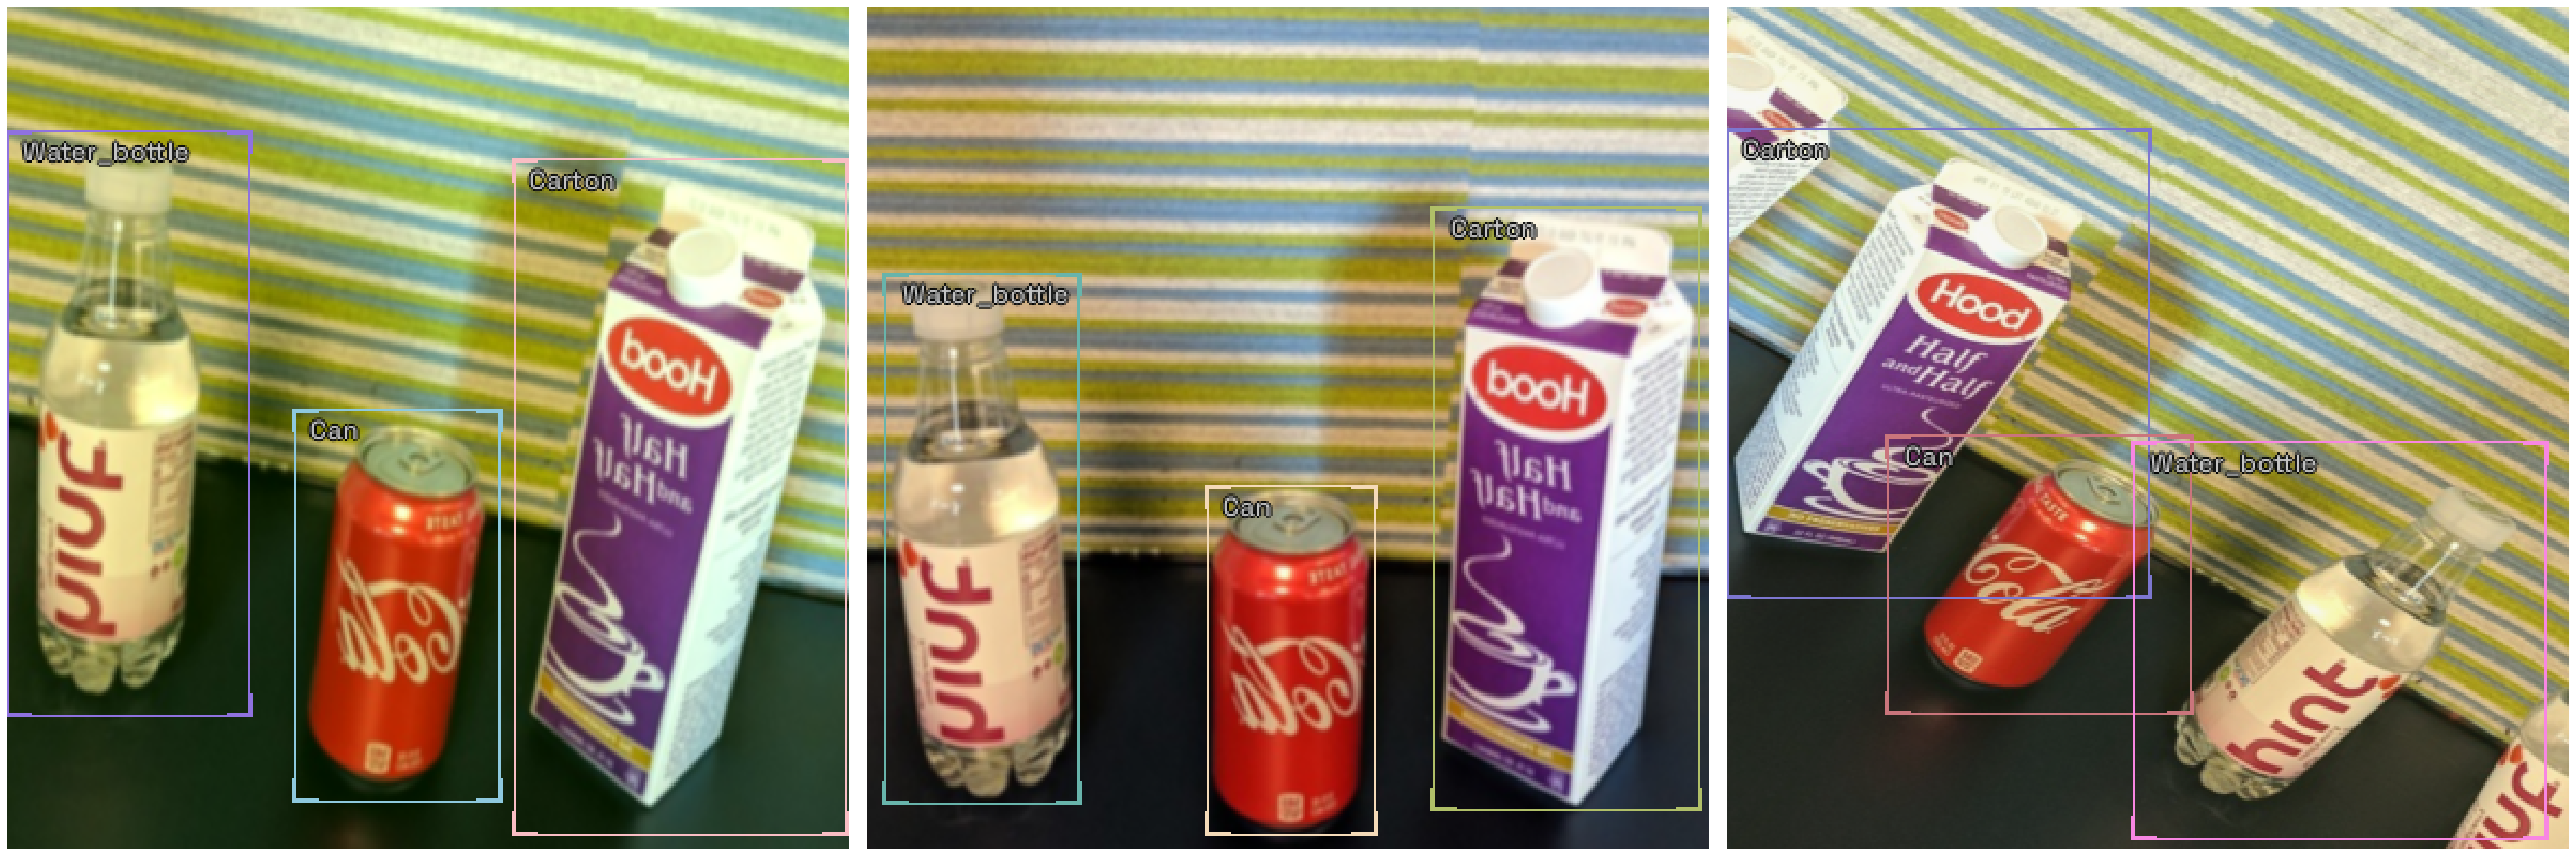

In [18]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

## DataLoader

In [19]:
# DataLoaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

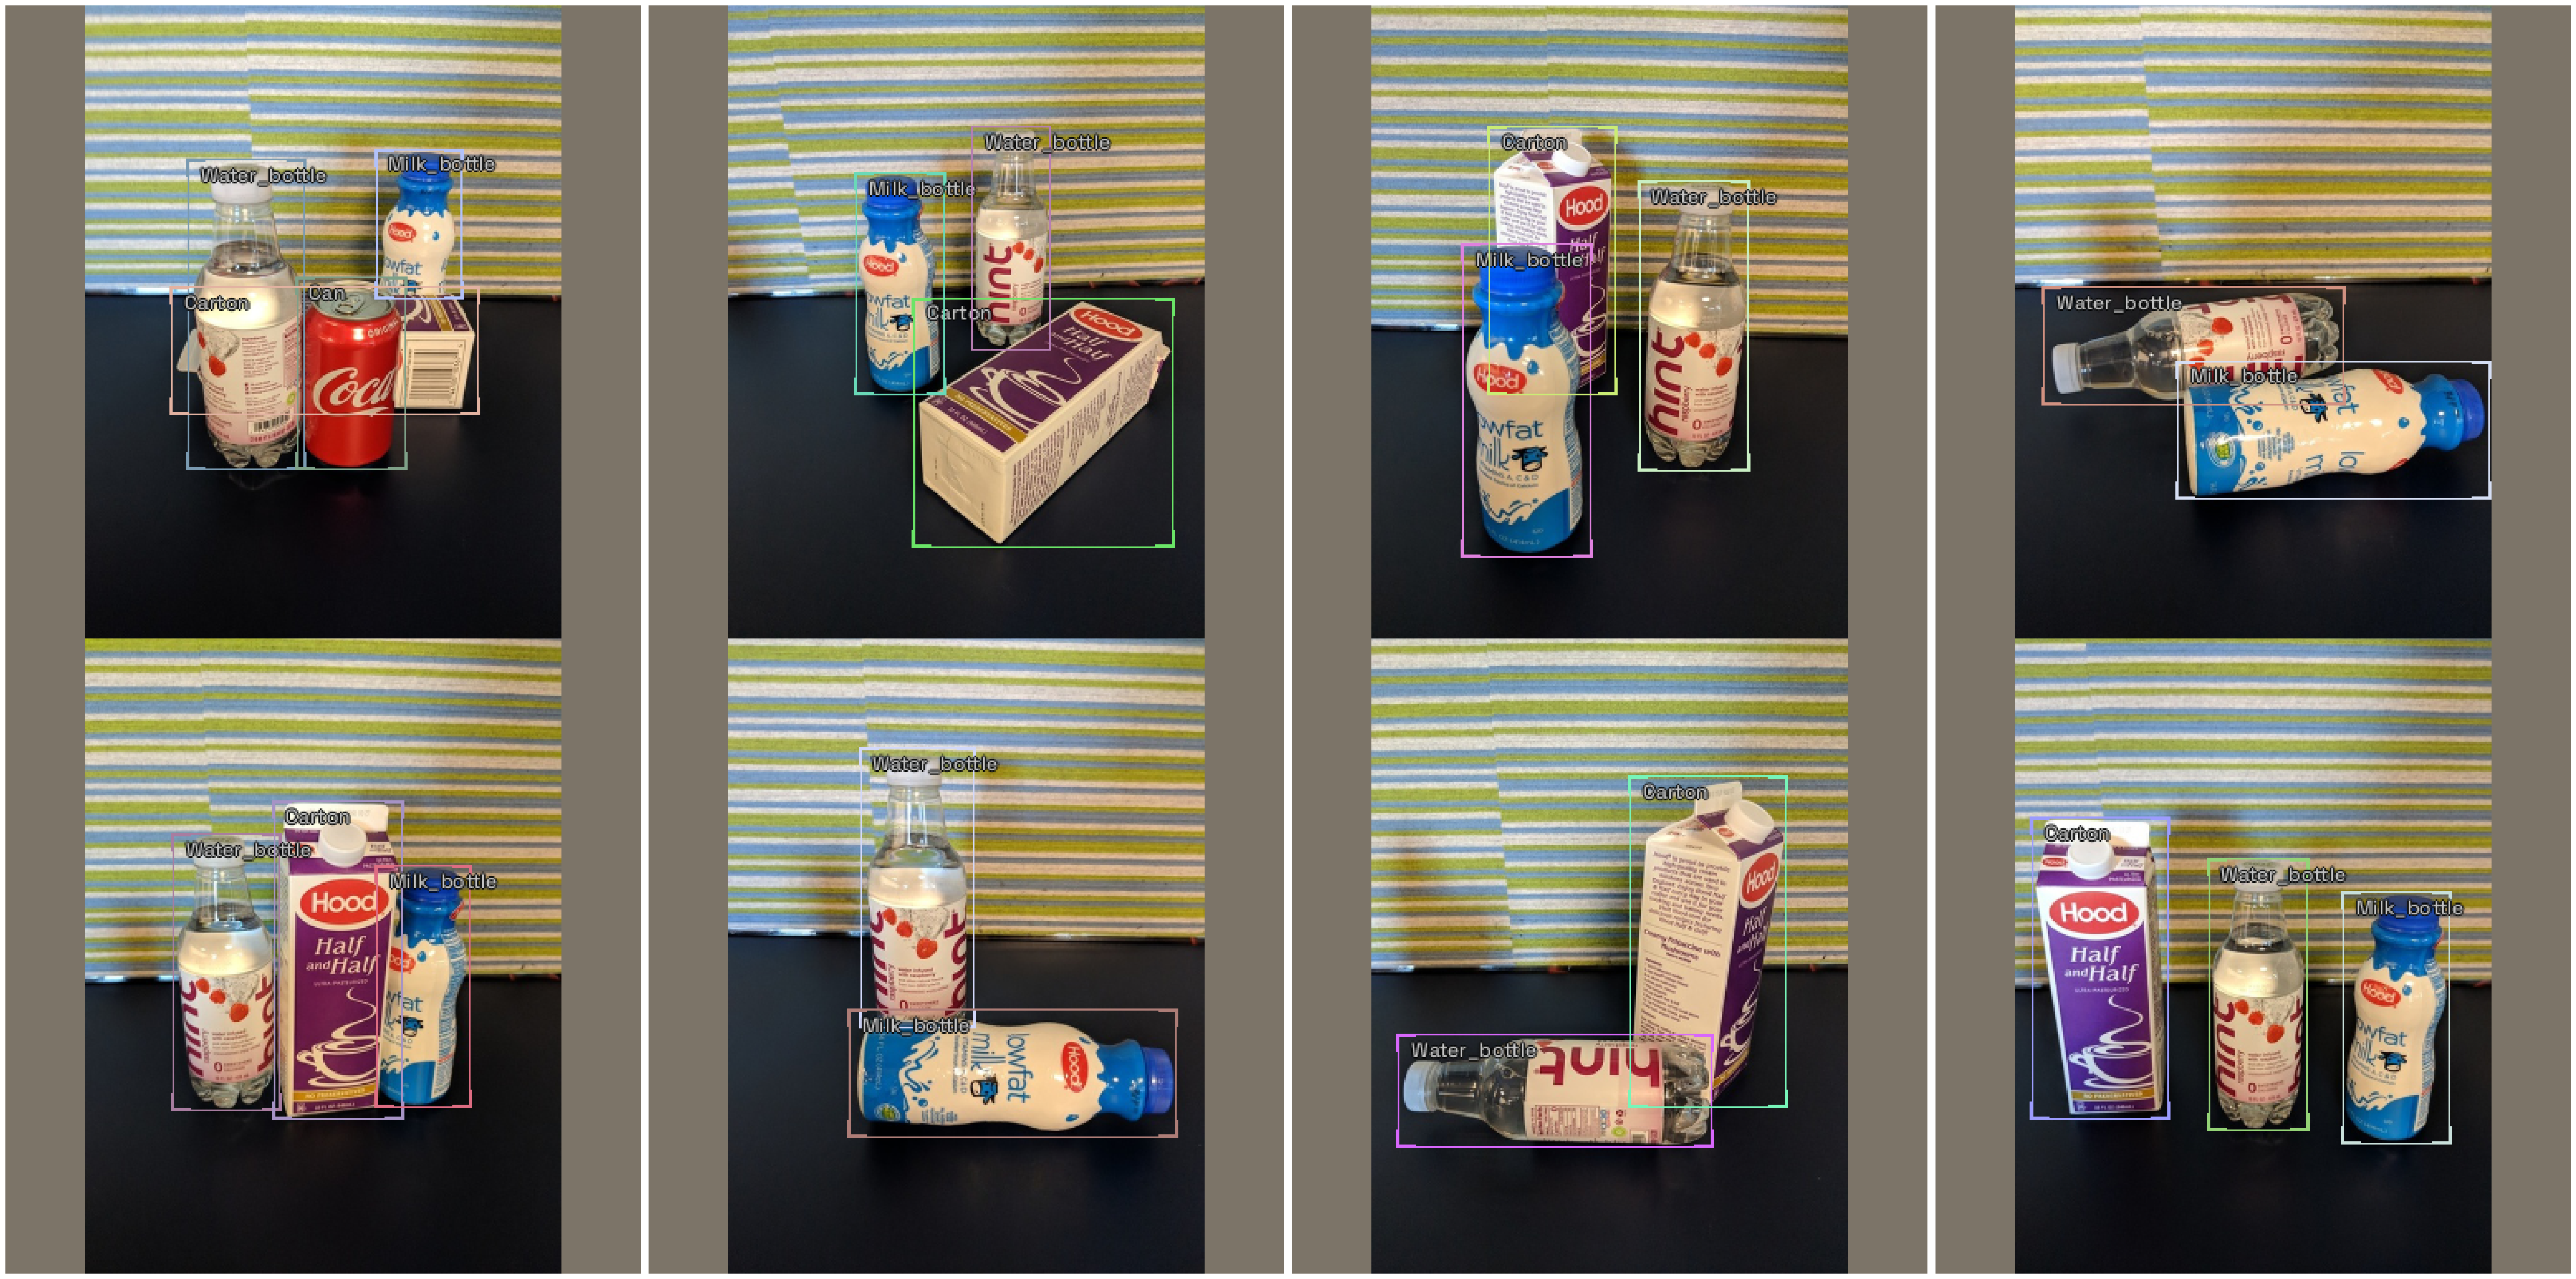

In [20]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

## Model

Now that we determined the number of classes (`num_classes`), we can create our `model` object. We create a `backbone` object on-the-fly, and we can pass the `pretrained` argument. `pretrained=True` is a default argument. Therefore, we don't need to pass it. We are doing it, here below, for illustration purposes.

> Note: We only pass `img_size` to the EfficientDet models as shown here below

In [2]:
# pretrained=True is a default setting, and can be omitted
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map)) 

# EfficietDet and YOLOv5 requires img_size
# model = model_type.model(backbone=backbone(), num_classes=len(parser.class_map), img_size=384)

## Metrics

In [23]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training

IceVision is an agnostic framework meaning it can be plugged to other DL framework such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  

You could also plug to oth DL framework using your own custom code.

### Training using fastai

In [24]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

In [4]:
learn.lr_find()

# For Sparse-RCNN, use lower `end_lr`
# learn.lr_find(end_lr=0.005)

In [1]:
learn.fine_tune(20, 1e-2, freeze_epochs=1)

### Training using Lightning

In [ ]:
class LightModel(model_type.lightning.ModelAdapter):
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=1e-4)
    
light_model = LightModel(model, metrics=metrics)

In [ ]:
trainer = pl.Trainer(max_epochs=20, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

## Show Results

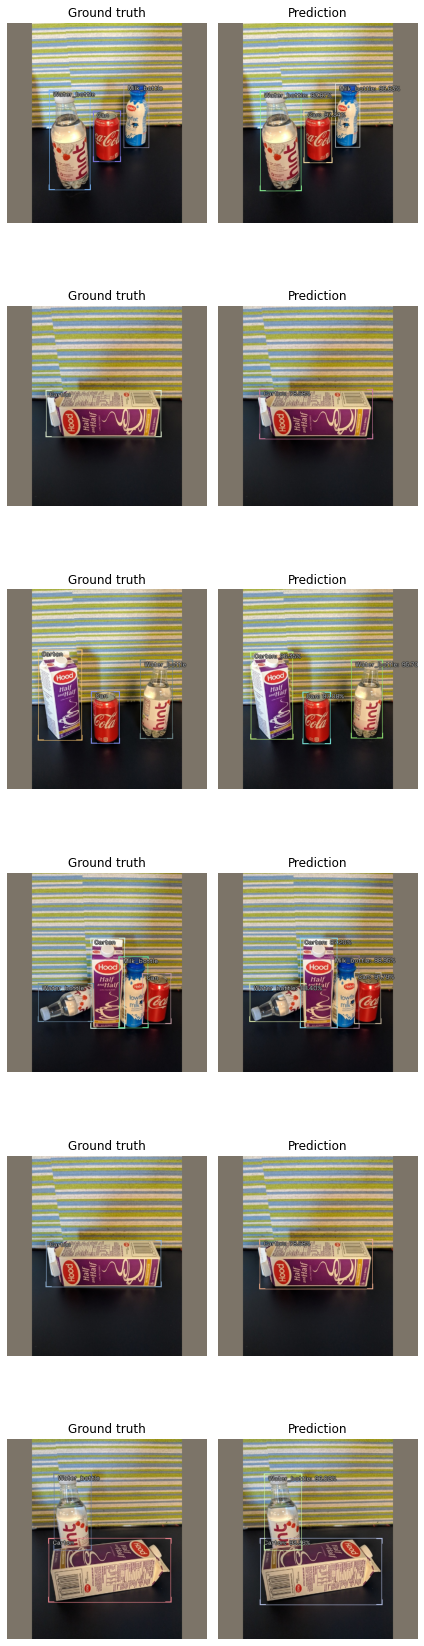

In [27]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

## Inference

### Predicting a batch of images

Instead of predicting a whole list of images at one, we can process small batches at the time: This option is more memory efficient. 


> NOTE: For a more detailed look at inference check out the [inference tutorial](https://airctic.com/dev/inference/)

In [28]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_dl(model, infer_dl, keep_images=True)

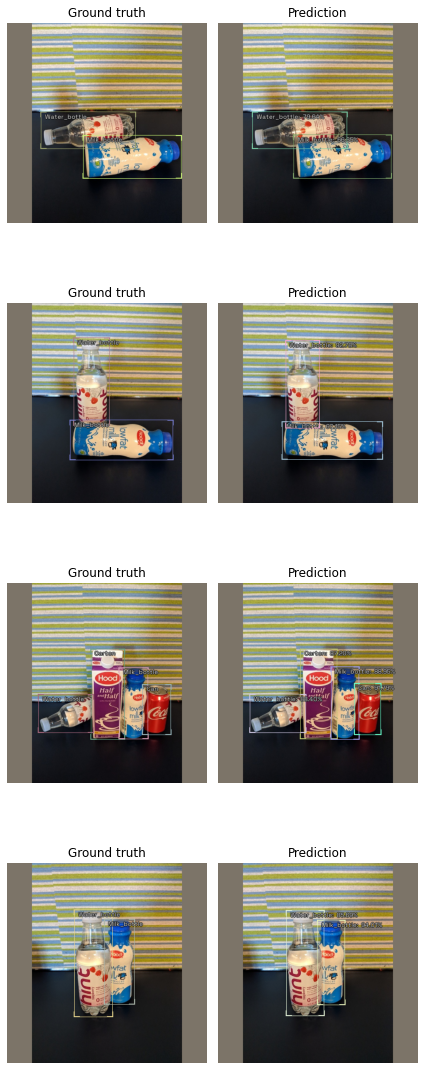

In [29]:
show_preds(preds=preds[:4])

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).